In [298]:
# Set up & handling the data
import os
os.chdir('C:\\Users\\M246047\\Documents\\Python')
import csv
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings(action="ignore")

# Cleaning the data

# Transforming the data
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats.mstats import winsorize

import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn import ensemble   # we'll use ensemble random forests


# Running the models
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVR


# Not using these yet
# import re                                   # clean data
# from sklearn import linear_model
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import normalize
# import statsmodels.formula.api as smf
# from sqlalchemy import create_engine
# from scipy.stats import bartlett
# from scipy.stats import levene
# from statsmodels.tsa.stattools import acf
# import statsmodels.api as sm
# import seaborn as sns
# from statsmodels.tools.eval_measures import mse, rmse
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# from sklearn.linear_model import Lasso
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import ElasticNet
# from sklearn.linear_model import LassoCV
# from sklearn.linear_model import RidgeCV
# from sklearn.linear_model import ElasticNetCV
# from sklearn.linear_model import LinearRegression


# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

## Introduction

Analyzing the [IMDB Movie dataset](https://www.kaggle.com/jyoti1706/imdbmoviesdataset), I'm going to look at if we can predict how successful a movie is using the adjusted revenue as the measure of success. With nearly 11,000 movies and twenty variables, I should be able to choose features correlated with the revenue to create a good model. 

## Cleaning

There are 6,016 rows with an adjused revenue of $0. I'm going to remove these rows as 

Columns homepage, director, cast, keywords, tagline, and production_companies are missing values. For the homepage column, I will assumme that a missing value indicates that a movie does not have a homepage. I'll create a dummy variable in which 0 indicates there is no homepage and 1 indicates that one exists. Only one movie is missing the director and five movies are missing the cast, so I will look up this information and manually add it to the dataset. I will set cells missing values for keywords, tagline, and production companies to 'Unknown'.

Off the bat, popularity, budget, revenue, runtime, and votecount have clear high outliers. I'm going to take a look at these columns and see if we can derive what may be going on. Cast, homepage, director, tagline, keywords, overview, genres, and production_companies are missing values. Nearly all of these contain categorical data so I will fill the values as best as I can and remove rows and/or columns I cannot. 



In [270]:
movies = pd.read_csv('IMDBMovies.csv')
movies = pd.DataFrame(movies)
print(movies.columns)
print('\n', movies.describe())
movies.info()

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

               id  popularity        budget        revenue   runtime  \
count  10866.000   10866.000     10866.000      10866.000 10866.000   
mean   66064.177       0.646  14625701.094   39823319.793   102.071   
std    92130.137       1.000  30913213.831  117003486.582    31.381   
min        5.000       0.000         0.000          0.000     0.000   
25%    10596.250       0.208         0.000          0.000    90.000   
50%    20669.000       0.384         0.000          0.000    99.000   
75%    75610.000       0.714  15000000.000   24000000.000   111.000   
max   417859.000      32.986 425000000.000 2781505847.000   900.000   

       vote_count  vote_ave

Split genres, keywords, names?
Tagline - number of words?
Homepage - dummies into yes and no?
Cast - split on each actor (|), grab each member, create dummy variables based on category

Cast
homepage - dummies)
tagline - none
keywords - none
production_companies

In [271]:
pd.options.display.max_columns = None
movies[movies['revenue_adj'] == 0 ].shape
# pd.options.display.max_columns = None
# movies.head()
movies = movies[movies.revenue_adj != 0]
print(movies.describe())
movies.info()
movies.head()

              id  popularity        budget        revenue  runtime  \
count   4850.000    4850.000      4850.000       4850.000 4850.000   
mean   44575.001       1.045  29569700.632   89220658.325  107.965   
std    72361.406       1.357  40513434.965  162068389.382   21.113   
min        5.000       0.001         0.000          2.000   15.000   
25%     8286.000       0.388   1700000.000    7708081.250   95.000   
50%    12154.500       0.680  15000000.000   31826540.000  104.000   
75%    43956.500       1.210  40000000.000   99918234.250  117.000   
max   417859.000      32.986 425000000.000 2781505847.000  705.000   

       vote_count  vote_average  release_year    budget_adj    revenue_adj  
count    4850.000      4850.000      4850.000      4850.000       4850.000  
mean      436.216         6.149      2000.922  35161017.182  115077354.868  
std       806.416         0.799        11.569  43756717.053  198841916.046  
min        10.000         2.100      1960.000         0.000  

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000


## Genres Variable

The contents in the genres column contain multiple genres separated by the a symbol. I'm going to separate the genres in each cell, find all unique values, and create a dummy column for each genre. If a movie contains (?) that genre, the column will have the value one in the corresponding cell. Otherwise, the column for that movie will contain a zero.

In [272]:
# Create a list of genres

Genres = movies.genres.unique()
genres = []
flatten_genres = []

for list_of_genres in Genres:
    movies_genres = list_of_genres.split('|')
    genres.append(movies_genres)
    for i in range(len(genres)): #Traversing through the main list
        for j in range (len(genres[i])): #Traversing through each sublist
            flatten_genres.append(genres[i][j]) #Appending elements into our flat_list

unique_genres = set(flatten_genres)
print(unique_genres)

# Creating dummy columns for each genre
for genre in unique_genres:
    movies[genre] = 0

{'Animation', 'Comedy', 'War', 'Drama', 'Family', 'Music', 'Horror', 'Mystery', 'Thriller', 'Documentary', 'Romance', 'Fantasy', 'Foreign', 'TV Movie', 'Western', 'Action', 'History', 'Science Fiction', 'Crime', 'Adventure'}


In [273]:
# Populating each genre column
def populating_genres(df, genre_list):
    for i, row in df.iterrows():
        movies_genres = df.loc[i]['genres']
        for genre in genre_list:
            if genre in movies_genres:
                df.at[i, genre] = 1
    return df

populating_genres(movies, unique_genres)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Animation,Comedy,War,Drama,Family,Music,Horror,Mystery,Thriller,Documentary,Romance,Fantasy,Foreign,TV Movie,Western,Action,History,Science Fiction,Crime,Adventure
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0
5,281957,tt1663202,9.111,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,http://www.foxmovies.com/movies/the-revenant,Alejandro GonzÃƒÂ¡lez IÃƒÂ±ÃƒÂ¡rritu,"(n. One who has returned, as if from the dead.)",father-son relationship|rape|based on novel|mo...,"In the 1820s, a frontiersman, Hugh Glass, sets...",156,Western|Drama|Adventure|Thriller,Regency Enterprises|Appian Way|CatchPlay|Anony...,12/25/2015,3929,7.200,2015,124199945.400,490314247.000,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1
6,87101,tt1340138,8.654,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,http://www.terminatormovie.com/,Alan Taylor,Reset the future,saving the world|artificial intelligence|cybor...,"The year is 2029. John Connor, leader of the r...",125,Science Fiction|Action|Thriller|Adventure,Paramount Pictures|Skydance Productions,6/23/2015,2598,5.800,2015,142599937.300,405355075.700,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1
7,286217,tt3659388,7.667,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,http://www.foxmovies.com/movies/the-martian,Ridley Scott,Bring Him Home,based on novel|mars|nasa|isolation|botanist,"During a manned mission to Mars, Astronaut Mar...",141,Drama|Adventure|Science Fiction,Twentieth Century 

## Cast Variable

Each cell in the cast column has up to the five central actors and/or actresses in the movie. I have found a list of the top 100 movie stars from 1960 and to make use of this variable, I will create a new feature called 'stars' which holds the number of actors each movie has from this list. We would expect to see that movies with any/more stars than others would be more successful.

In [274]:
# Adding the missing top five cast members
movies[movies['cast'].isnull()]
movies.at[1088, 'cast'] = 'Vivian Maier|John Maloof|Daniel Arnaud|Simone Amédé|Maren Baylaender'
movies.at[4127, 'cast'] = 'Belladonna|Marlon Brando|Elton John|Julia Louis-Dreyfus|Madonna'
movies.at[4889, 'cast'] = 'Jay Bastian|Joe Biden|Cait Brasel|Gene Burris Jr.|Dinesh D\'Souza'
movies.at[7813, 'cast'] = 'Dylan Avery|Mahmoud Ahmad|Ahmed Al-Ghamdi|Hamza Al-Ghamdi|Saeed Al-Ghamdi'
movies.at[9564, 'cast'] = 'Christie Brinkley|David Brinkley|Pope John Paul II|Dan Rather|Cheryl Tiegs'
movies[movies['cast'].isnull()]

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Animation,Comedy,War,Drama,Family,Music,Horror,Mystery,Thriller,Documentary,Romance,Fantasy,Foreign,TV Movie,Western,Action,History,Science Fiction,Crime,Adventure


In [275]:
# Splitting the cast information into lists
movies['cast'] = movies['cast'].apply(lambda x: x.split('|'))

In [276]:
# Importing the top 100 stars and removing 'Actor' and 'Actress' so we just have names in the stars dataframe

top_100_stars = pd.read_csv('top_100_stars.csv')
top_100_stars = pd.DataFrame(top_100_stars)


top_100_stars['Name'] = top_100_stars['Name'].str.replace(' Actor', '')
top_100_stars['Name'] = top_100_stars['Name'].str.replace(' Actress', '')

# Converting the series to a list so we can compare it to the cast lists
top_100_stars = top_100_stars['Name'].tolist()
top_100_stars[:5]

['Harrison Ford', 'John Wayne', 'Clark Gable', 'James Stewart', 'Gary Cooper']

In [277]:
movies['number_of_stars'] = [len(set(i) & set(top_100_stars)) for i in movies['cast']]
movies.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Animation,Comedy,War,Drama,Family,Music,Horror,Mystery,Thriller,Documentary,Romance,Fantasy,Foreign,TV Movie,Western,Action,History,Science Fiction,Crime,Adventure,number_of_stars
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",http://www.furious7.com/,James Wan,Vengeance Hits Home,car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0


In [278]:
movies[movies['number_of_stars'] > 2].head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Animation,Comedy,War,Drama,Family,Music,Horror,Mystery,Thriller,Documentary,Romance,Fantasy,Foreign,TV Movie,Western,Action,History,Science Fiction,Crime,Adventure,number_of_stars
2692,6073,tt0236493,0.747,57000000,147845033,The Mexican,"[Brad Pitt, Julia Roberts, James Gandolfini, J...",NaN,Gore Verbinski,Love with the safety off.,kidnapping|pistol,"Jerry Welbach, a reluctant bagman, has been gi...",123,Action|Comedy|Crime|Romance,DreamWorks SKG|Newmarket Capital Group|Lawrenc...,3/1/2001,258,5.700,2001,70194822.650,182069401.300,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,3
4590,87496,tt1381404,0.438,0,19633027,The Company You Keep,"[Robert Redford, Shia LaBeouf, Julie Christie,...",NaN,Robert Redford,The greatest manhunt in history.,NaN,A thriller centered on a former Weather Underg...,121,Drama|Thriller,Wildwood Enterprises|Kingsgate Films|Brightlig...,9/6/2012,177,5.800,2012,0.000,18646355.120,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
7004,866,tt0308644,1.428,25000000,116766556,Finding Neverland,"[Johnny Depp, Kate Winslet, Julie Christie, Du...",NaN,Marc Forster,Where will your imagination take you?,london|scotland|parents kids relationship|beco...,Finding Neverland is an amusing drama about ho...,106,Drama,Miramax Films|Film Colony,10/17/2004,695,7.100,2004,28861135.000,134800613.400,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
7442,4515,tt0891527,1.156,35000000,63215872,Lions for Lambs,"[Robert Redford, Meryl Streep, Tom Cruise, Mic...",NaN,Robert Redford,"If you don't STAND for something, you might FA...",journalist|terrorist|war against terror|extern...,Three stories told simultaneous in ninety minu...,92,Action|Adventure|Drama|History,Cruise/Wagner Productions|United Artists|Wildw...,10/22/2007,119,5.700,2007,36808400.390,66482146.510,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,3
8261,33,tt0105695,0.842,14000000,159157447,Unforgiven,"[Clint Eastwood, Gene Hackman, Morgan Freeman,...",NaN,Clint Eastwood,Some legends will never be forgotten. Some wro...,prostitute|sheriff|bounty|regret|right and jus...,"William Munny is a retired, once-ruthless kill...",131,Western,Warner Bros.,8/7/1992,602,7.500,1992,21756339.560,247334532.900,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3


## Tagline Variable

For this variable, I will create a new column called 'tagline_score' for the number of words in the tagline to see if there is any correlation between tagline length and revenue. A cell will contain a zero if there are fewer than six words in a tagline, a one if there are more, and a two if there is no tagline in the data. My hypothesis is that movies with shorter taglines fare better - short and sweet is key!

In [279]:
movies['tagline'] = movies['tagline'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
movies['tagline'] = movies['tagline'].str.split(' ')
movies['tagline_length'] = movies['tagline'].apply(lambda x: 0 if len(x) < 6  else 1 if len(x) >= 6 else 2)
movies.head()

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Animation,Comedy,War,Drama,Family,Music,Horror,Mystery,Thriller,Documentary,Romance,Fantasy,Foreign,TV Movie,Western,Action,History,Science Fiction,Crime,Adventure,number_of_stars,tagline_length
0,135397,tt0369610,32.986,150000000,1513528810,Jurassic World,"[Chris Pratt, Bryce Dallas Howard, Irrfan Khan...",http://www.jurassicworld.com/,Colin Trevorrow,"[The, park, is, open.]",monster|dna|tyrannosaurus rex|velociraptor|island,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/2015,5562,6.500,2015,137999939.300,1392445893.000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0
1,76341,tt1392190,28.420,150000000,378436354,Mad Max: Fury Road,"[Tom Hardy, Charlize Theron, Hugh Keays-Byrne,...",http://www.madmaxmovie.com/,George Miller,"[What, a, Lovely, Day.]",future|chase|post-apocalyptic|dystopia|australia,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/2015,6185,7.100,2015,137999939.300,348161292.500,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,1,0
2,262500,tt2908446,13.113,110000000,295238201,Insurgent,"[Shailene Woodley, Theo James, Kate Winslet, A...",http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,"[One, Choice, Can, Destroy, You]",based on novel|revolution|dystopia|sequel|dyst...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/2015,2480,6.300,2015,101199955.500,271619025.400,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0
3,140607,tt2488496,11.173,200000000,2068178225,Star Wars: The Force Awakens,"[Harrison Ford, Mark Hamill, Carrie Fisher, Ad...",http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,"[Every, generation, has, a, story.]",android|spaceship|jedi|space opera|3d,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/2015,5292,7.500,2015,183999919.000,1902723130.000,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,1,0
4,168259,tt2820852,9.335,190000000,1506249360,Furious 7,"[Vin Diesel, Paul Walker, Jason Statham, Miche...",http://www.furious7.com/,James Wan,"[Vengeance, Hits, Home]",car race|speed|revenge|suspense|car,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/2015,2947,7.300,2015,174799923.100,1385748801.000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0


# Homepage Variable

I will create a dummy variable that reflects whether or not a movie has a homepage. This column will contain a one if a movie has a homepage and a zero if it does not.

In [280]:
movies['homepage_dummy'] = movies['homepage'].apply(lambda x: 0 if pd.isnull(x) else 1)

## Production Companies Variable

I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [281]:
movies['production_companies'] = movies['production_companies'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
print('There are', len(movies['production_companies'].unique()), 'production companies.')

There are 3683 production companies.


## Keywords Variable

I'm not sure yet how to handle this variable, but will fill any empty cells with 'Unknown' for now.

In [282]:
movies['keywords'] = movies['keywords'].apply(lambda x: 'Unknown' if pd.isnull(x) else x)
len(movies[movies['keywords'] == 'Unknown'])

235

## Director Variable

One movie is missing its director, so I will manually add it.

In [285]:
movies.director.isnull()
movies.at[1088, 'director'] = 'Aziz Mirza'
print('There are', len(movies.director.unique()), 'unique directors.')

There are 2134 unique directors.


## Correlation Matrix

Our first look at the correlation matrix provides some insight into the relationships between the variables and our arget, the adjusted revenue. There are strong relationships between budget and popularity which is intuitive, but there's quite a strong correlation between vote count, stronger even than the average vote which is interesting. Vote count and popularity (the average number of visits the IMDB page receives per week) are strongly correlated so I'm going to combine them into a single feature. Family and Animation genres have a fairly strong correlation at 0.516, so I'll combine them as well.

The features I'll start with are vc_pop (the combination of vote_count and popularity), budget_adj, runtime, vote_average, number_of_stars, and Adventure. 

In [286]:
movies.corr()

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj,Animation,Comedy,War,Drama,Family,Music,Horror,Mystery,Thriller,Documentary,Romance,Fantasy,Foreign,TV Movie,Western,Action,History,Science Fiction,Crime,Adventure,number_of_stars,tagline_length,homepage_dummy
id,1.000,0.140,-0.068,-0.041,-0.031,0.070,0.008,0.507,-0.146,-0.115,0.013,-0.045,0.001,0.045,-0.048,0.035,-0.001,-0.033,-0.038,0.067,-0.042,-0.065,-0.021,-0.006,-0.013,-0.089,-0.007,-0.055,-0.060,-0.074,-0.099,-0.142,0.148
popularity,0.140,1.000,0.481,0.629,0.201,0.788,0.289,0.170,0.440,0.562,0.084,-0.085,0.012,-0.112,0.064,-0.044,-0.073,0.004,0.047,-0.086,-0.072,0.127,-0.050,-0.008,-0.005,0.162,-0.020,0.185,-0.005,0.227,0.083,-0.039,0.248
budget,-0.068,0.481,1.000,0.704,0.247,0.586,0.037,0.238,0.964,0.561,0.200,-0.078,0.030,-0.183,0.188,-0.053,-0.127,-0.001,0.032,-0.101,-0.102,0.249,-0.051,-0.009,0.037,0.278,0.021,0.183,-0.019,0.369,0.108,-0.058,0.223
revenue,-0.041,0.629,0.704,1.000,0.238,0.764,0.207,0.121,0.674,0.905,0.186,-0.041,0.005,-0.163,0.180,-0.033,-0.090,-0.018,-0.016,-0.071,-0.057,0.204,-0.040,-0.004,-0.012,0.177,-0.022,0.132,-0.041,0.306,0.126,-0.040,0.237
runtime,-0.031,0.201,0.247,0.238,1.000,0.252,0.308,-0.100,0.304,0.264,-0.211,-0.243,0.212,0.280,-0.163,0.005,-0.156,0.039,0.017,-0.067,0.028,-0.025,0.022,-0.013,0.082,0.082,0.259,-0.016,0.050,0.076,0.234,0.013,0.035
vote_count,0.070,0.788,0.586,0.764,0.252,1.000,0.351,0.197,0.533,0.667,0.093,-0.105,0.014,-0.114,0.060,-0.053,-0.072,-0.002,0.032,-0.069,-0.091,0.140,-0.041,-0.007,0.002,0.196,-0.017,0.199,0.009,0.240,0.094,-0.051,0.297
vote_average,0.008,0.289,0.037,0.207,0.308,0.351,1.000,-0.095,0.049,0.242,0.059,-0.138,0.088,0.242,-0.019,0.052,-0.210,0.007,-0.086,0.129,0.004,-0.053,-0.002,-0.010,0.037,-0.102,0.087,-0.068,0.064,-0.020,0.151,0.047,0.100
release_year,0.507,0.170,0.238,0.121,-0.100,0.197,-0.095,1.000,0.083,-0.100,0.056,0.003,-0.047,0.019,-0.009,-0.036,-0.044,-0.019,-0.002,0.076,-0.011,-0.020,0.004,-0.006,-0.089,-0.054,-0.036,-0.047,-0.036,-0.058,-0.220,-0.192,0.410
budget_adj,-0.146,0.440,0.964,0.674,0.304,0.533,0.049,0.083,1.000,0.593,0.185,-0.089,0.057,-0.179,0.187,-0.043,-0.132,0.003,0.038,-0.112,-0.101,0.250,-0.055,-0.009,0.050,0.298,0.053,0.194,-0.015,0.388,0.158,-0.026,0.149
revenue_adj,-0.115,0.562,0.561,0.905,0.264,0.667,0.242,-0.100,0.593,1.000,0.155,-0.048,0.020,-0.144,0.165,-0.013,-0.081,-0.022,-0.007,-0.076,-0.050,0.173,-0.042,-0.004,0.001,0.174,-0.009,0.125,-0.035,0.305,0.187,-0.002,0.165


In [287]:
movies['vc_pop'] = movies['vote_count'] * movies['popularity']
corr_mat = movies.corr().loc[:, ["revenue_adj"]].sort_values(by='revenue_adj', ascending=False)
corr_mat

,revenue_adj
revenue_adj,1.000
revenue,0.905
vote_count,0.667
budget_adj,0.593
popularity,0.562
budget,0.561
vc_pop,0.478
Adventure,0.305
runtime,0.264
vote_average,0.242


## Testing for Outliers and Normality

The Jarque Bera and Normality tests produce p-values of or extremely close to zero. However, when I plot the features it is clear that they are not normal and have outliers. How/why is this possible?

A note on outliers: vc_pop seems legit - neither the vote_count nor the popularity appear to be errors
budget_adj - legit, did the research for the top couple movies

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for revenue_adj feature. 









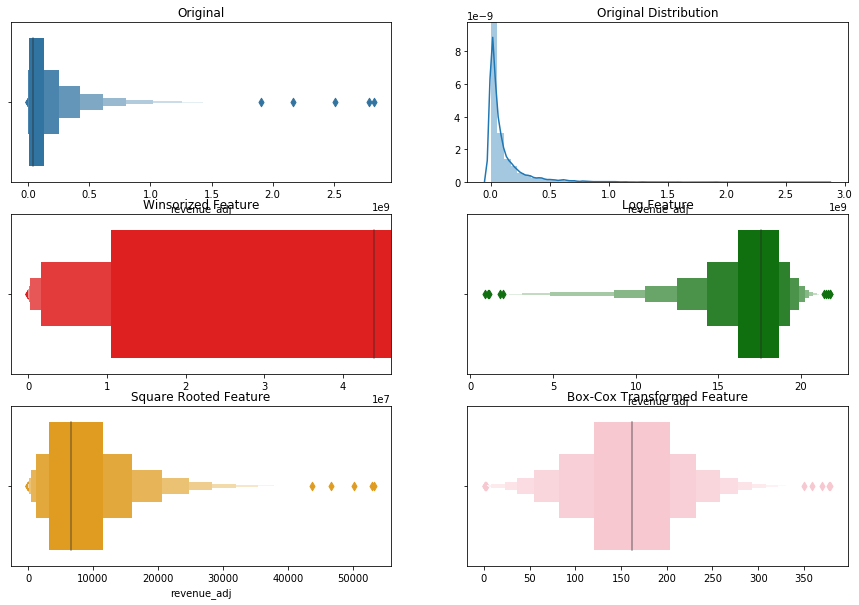

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for vc_pop feature. 









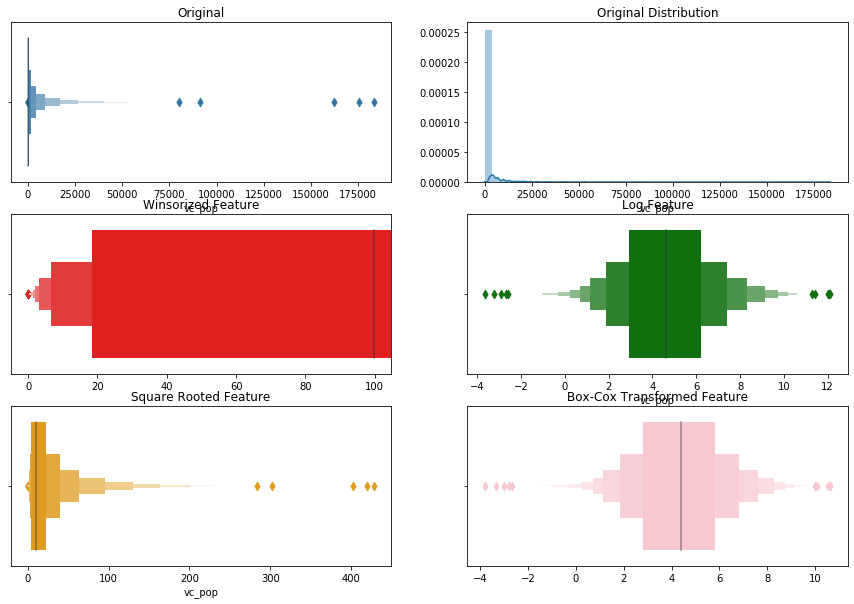

C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all p

budget_adj Data isn't positive.

 Outlier Visualization for budget_adj feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


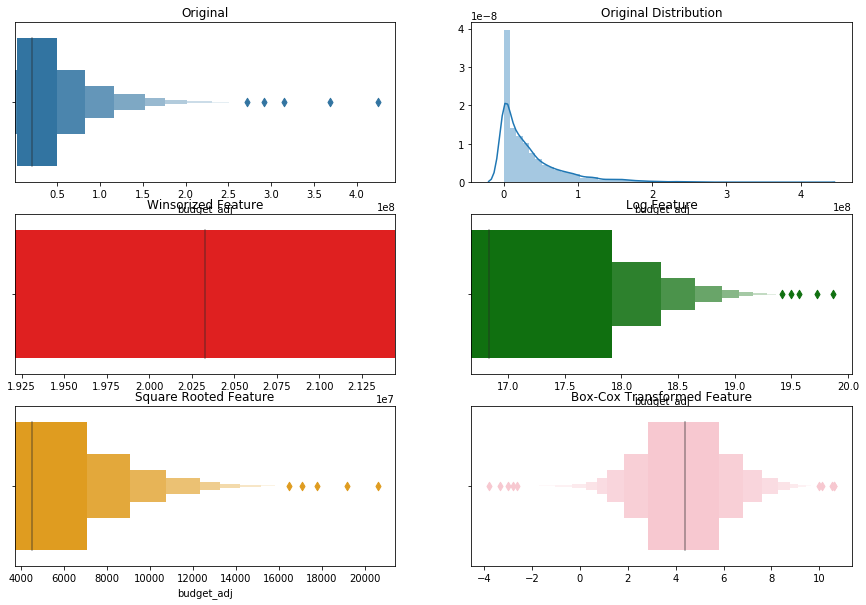

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.



 Outlier Visualization for runtime feature. 



'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

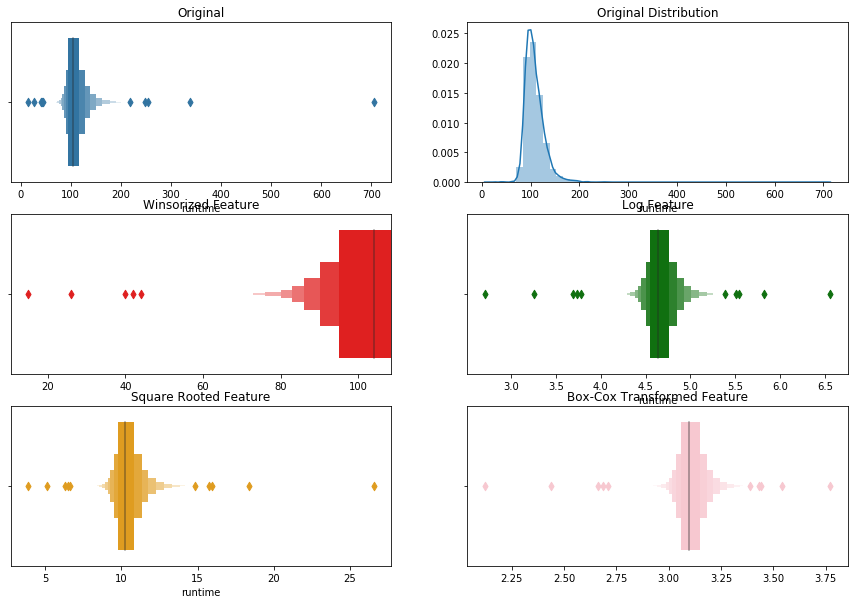

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches


 Outlier Visualization for vote_average feature. 









'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


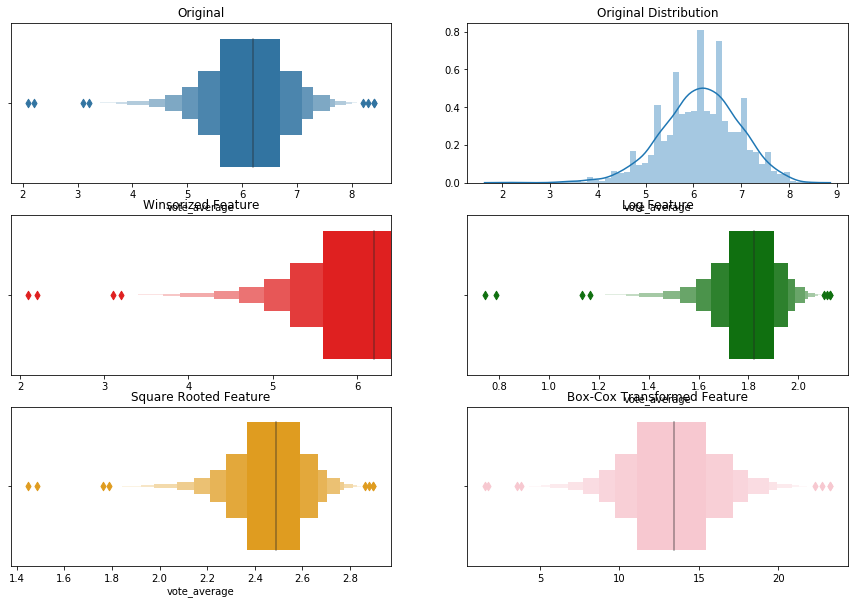

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


number_of_stars Data isn't positive.

 Outlier Visualization for number_of_stars feature. 







'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


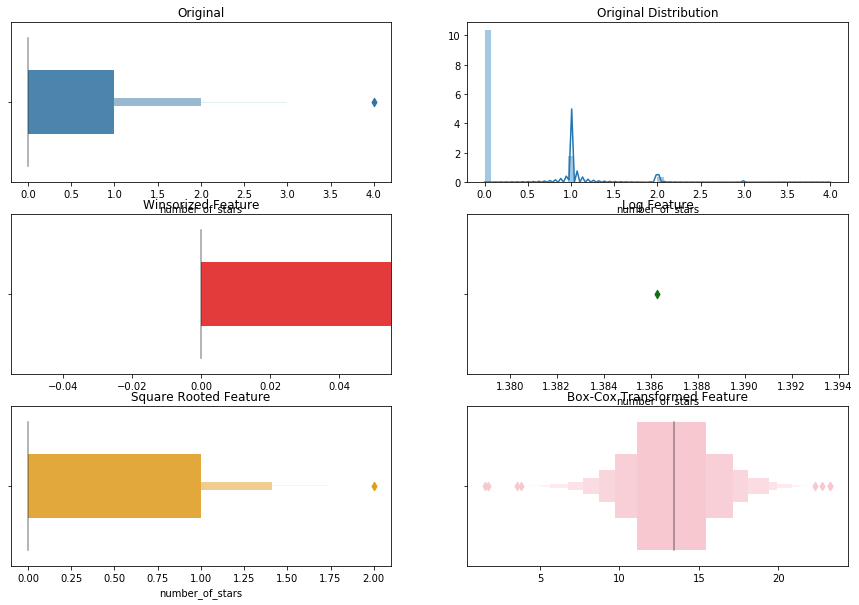

In [288]:
# Specify a list with features you want to test for normality. (You should ideally do this for all features in your dataset!)
# Visuals for outliers and normality
features_to_test = ['revenue_adj','vc_pop', 'budget_adj', 'runtime', 'vote_average', 'number_of_stars']

for feat in features_to_test:
    winsorized_feature = winsorize(movies[feat], (0, 0.10))
    log_feature = np.log(movies[feat])
    sqrt_feature = np.sqrt(movies[feat])
    try:
        bc_feature,_ = stats.boxcox(movies[feat])#power_transform(np.array(fifa["Wage"]).reshape(1,-1)).reshape(-1,1)
    except ValueError: 
        print(feat, 'Data isn\'t positive.')
    
    print('\n Outlier Visualization for', feat, 'feature. \n')
    plt.figure(figsize = (15,10))
    plt.tight_layout()
    plt.subplot(3, 2, 1)
    sns.boxenplot(x=feat, data=movies)
    plt.title('Original')
    print('\n')
    plt.subplot(3, 2, 2)
    sns.distplot(movies[feat])
    plt.title('Original Distribution')
    print('\n')
    plt.subplot(3, 2, 3)
    sns.boxenplot(winsorized_feature, color='red')
    plt.title('Winsorized Feature')
    plt.subplot(3, 2, 4)
    sns.boxenplot(log_feature, color='green')
    plt.title('Log Feature')
    print('\n')
    plt.subplot(3, 2, 5)
    sns.boxenplot(sqrt_feature, color='orange')
    plt.title('Square Rooted Feature')
    plt.subplot(3, 2, 6)
    sns.boxenplot(bc_feature, color='pink')
    plt.title('Box-Cox Transformed Feature')
    plt.show()

In [289]:
# Testing to Normality

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on revenue_adj:
Jarque-Bera test statistics for revenue_adj is 226940.3455244923 and p value is 0.0
Normality test statistics for revenue_adj is 4522.292435228974 and p value is 0.0

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27345131.383749064 and p value is 0.0
Normality test statistics for vc_pop is 9645.87772348386 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 10959.419887756596 and p value is 0.0
Normality test statistics for budget_adj is 2133.926912739724 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 3797640.9538830956 and p value is 0.0
Normality test statistics for runtime is 5921.175938826389 and p value is 0.0

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 112.99050060716442 and p value is 0.0
Normality test statistics for vote_average is 102.28513371965839 and p value is 6.1

## Update Variable Values

As I was visualizing the data, there were a few values that warranted further investigation, so I have updated them here.

In [290]:
# The budget_adj for The Warrior's way appears to have an extra 0 - multiple sources have the budget at $42 million
movies.loc[2244, 'budget_adj'] = 42500000

# Band of Brothers and Carlos are miniseries which accounts for their lengthy runtimes.
# We're only interested in movies, so I'll remove them from the dataset.
movies = movies[movies.runtime < 338]

movies.sort_values(by='vote_average', ascending=False)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,keywords,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj,Animation,Comedy,War,Drama,Family,Music,Horror,Mystery,Thriller,Documentary,Romance,Fantasy,Foreign,TV Movie,Western,Action,History,Science Fiction,Crime,Adventure,number_of_stars,tagline_length,homepage_dummy,vc_pop
4178,278,tt0111161,7.192,25000000,28341469,The Shawshank Redemption,"[Tim Robbins, Morgan Freeman, Bob Gunton, Will...",NaN,Frank Darabont,"[Fear, can, hold, you, prisoner., Hope, can, s...",prison|corruption|police brutality|prison cell...,Framed in the 1940s for the double murder of h...,142,Drama|Crime,Castle Rock Entertainment,9/10/1994,5754,8.400,1994,36777789.040,41693462.720,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,41382.992
7948,24128,tt0088178,0.283,1200000,4978922,Stop Making Sense,"[David Byrne, Tina Weymouth, Chris Frantz, Jer...",NaN,Jonathan Demme,"[Why, stop, making, sense?, Why, a, movie?, Wh...",concert,David Byrne walks onto the stage and does a so...,88,Documentary|Music,Talking Heads|Arnold Stiefel Company,11/16/1984,23,8.400,1984,2518850.447,10450966.590,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,6.513
7269,238,tt0068646,5.738,6000000,245066411,The Godfather,"[Marlon Brando, Al Pacino, James Caan, Richard...",http://www.thegodfather.com/,Francis Ford Coppola,"[An, offer, you, can't, refuse.]",italy|love at first sight|loss of father|patri...,"Spanning the years 1945 to 1955, a chronicle o...",175,Drama|Crime,Paramount Pictures|Alfran Productions,3/15/1972,3970,8.300,1972,31287365.590,1277913732.000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,22779.995
650,244786,tt2582802,4.780,3300000,13993093,Whiplash,"[Miles Teller, J.K. Simmons, Melissa Benoist, ...",http://sonyclassics.com/whiplash/,Damien Chazelle,"[The, road, to, greatness, can, take, you, to,...",jazz|obsession|conservatory|music teacher|new ...,"Under the direction of a ruthless instructor, ...",105,Drama|Music,Bold Films|Blumhouse Productions|Right of Way ...,10/10/2014,2372,8.200,2014,3039600.468,12888912.730,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,11339.154
2389,55244,tt1621444,0.052,0,1339650,Bill Cunningham New York,"[Bill Cunningham, Tom Wolfe, Anna Wintour, Car...",http://billcunninghamnewyork.com/,Richard Press,"[He, who, seeks, beauty,, will, find, it.]",fashion|milliner|new york city ballet|poncho|g...,Chronicles a man who is obsessively interested...,84,Documentary,First Thought Films,3/24/2010,16,8.100,2010,0.000,1339650.000,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0.837
10222,424,tt0108052,2.377,22000000,321265768,Schindler's List,"[Liam Neeson, Ben Kingsley, Ralph Fiennes, Car...",http://www.schindlerslist.com/,Steven Spielberg,"[Whoever, saves, one, life,, saves, the, world...",factory|concentration camp|hero|holocaust|worl...,The true story of how businessman Oskar Schind...,195,Drama|History|War,Universal Pictures|Amblin Entertainment,11/29/1993,2632,8.100,1993,33208339.160,484941026.500,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,1,6257.022
4177,680,tt0110912,8.094,8000000,213928762,Pulp Fiction,"[John Travolta, Samuel L. Jackson, Uma Thurman...",NaN,Quentin Tarantino,"[Just, because, you, are, a, character, doesn'...",transporter|brothel|drug dealer|boxer|massage,"A burger-loving hit man, his philosophical par...",154,Thriller|Crime,Miramax Films|A Band Apart|Jersey Films,10/14/1994,5343,8.100,1994,11768892.490,314713075.100,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,43244.928
4179,13,tt0109830,6.716,55000000,677945399,Forrest Gump,"[Tom Hanks, Robin Wright, Gary Sinise, Mykelti...",NaN,Robert Zemeckis,"[The, world, will, never, be, the, same,, once...",vietnam veteran|hippie|mentally disabled|runni...,A man with a low IQ has accomplished great thi...,142,Comedy|Drama|Romance,Paramount Pictures,7/6/1994,4856,8.100,1994,80911135.890,997333314.600,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,

## Normalizing the Features

In [291]:
# bc_revenue_adj,_ = stats.boxcox(movies['revenue_adj'])
# movies["norm_bc_revenue_adj"] = normalize(np.array(bc_revenue_adj).reshape(1,-1).reshape(-1,1))
movies["norm_winsorized_revenue_adj"] = normalize(np.array(winsorize(movies['revenue_adj'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vc_pop"] = normalize(np.array(winsorize(movies['vc_pop'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_sqrt_budget_adj"] = normalize(np.array(np.sqrt(movies['budget_adj'])).reshape(1,-1).reshape(-1,1))
movies["norm_winsorized_runtime"] = normalize(np.array(winsorize(movies['runtime'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_vote_average"] = normalize(np.array(winsorize(movies['vote_average'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)
movies["norm_winsorized_stars"] = normalize(np.array(winsorize(movies['number_of_stars'], (0, 0.10))).reshape(1,-1)).reshape(-1,1)


C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be se

In [292]:
# Testing to Normality
features_to_test = ['norm_winsorized_revenue_adj', 'vc_pop', 'budget_adj', 'runtime', 'vote_average', 'number_of_stars', 'Adventure']

# Now run each and one of the featues in above list. Locate the features in your data and calculate the statistics. 
for feat in features_to_test:
    jb_stats = stats.jarque_bera(movies[feat])
    norm_stats = stats.normaltest(movies[feat])
    
    print("Testing for normality on {}:".format(feat))
    print('Jarque-Bera test statistics for', feat, 'is {0} and p value is {1}'.format(jb_stats[0], jb_stats[1]))
    print('Normality test statistics for', feat, 'is {0} and p value is {1}\n'.format(norm_stats[0], norm_stats[1]))

Testing for normality on norm_winsorized_revenue_adj:
Jarque-Bera test statistics for norm_winsorized_revenue_adj is 1123.713683320344 and p value is 0.0
Normality test statistics for norm_winsorized_revenue_adj is 732.9389443861746 and p value is 6.987638685634258e-160

Testing for normality on vc_pop:
Jarque-Bera test statistics for vc_pop is 27312141.12901556 and p value is 0.0
Normality test statistics for vc_pop is 9641.034782879604 and p value is 0.0

Testing for normality on budget_adj:
Jarque-Bera test statistics for budget_adj is 8349.283276825254 and p value is 0.0
Normality test statistics for budget_adj is 1978.5585603222419 and p value is 0.0

Testing for normality on runtime:
Jarque-Bera test statistics for runtime is 5253.912712582582 and p value is 0.0
Normality test statistics for runtime is 1377.889780564115 and p value is 6.237862752850362e-300

Testing for normality on vote_average:
Jarque-Bera test statistics for vote_average is 113.7014676333856 and p value is 0.0

In [293]:
movies.corr().loc[:, ["norm_winsorized_revenue_adj"]].sort_values(by='norm_winsorized_revenue_adj', ascending=False)


,norm_winsorized_revenue_adj
norm_winsorized_revenue_adj,1.000
revenue_adj,0.808
revenue,0.761
budget_adj,0.658
norm_winsorized_vc_pop,0.641
budget,0.607
vote_count,0.583
popularity,0.498
vc_pop,0.327
runtime,0.301


In [ ]:
OLS, Random Forests, Nearest Neighbor, SVM

## Random Forests Ensemble

In [295]:
features = movies[['norm_winsorized_vc_pop', 'norm_sqrt_budget_adj', 'norm_winsorized_runtime',
                  'Adventure', 'norm_winsorized_stars', 'norm_winsorized_vote_average']]

rfr = ensemble.RandomForestRegressor(n_estimators=200)
Y = movies['norm_winsorized_revenue_adj']
X = movies[['norm_winsorized_vc_pop', 'norm_sqrt_budget_adj', 'norm_winsorized_runtime',
                  'Adventure', 'norm_winsorized_stars', 'norm_winsorized_vote_average']]

# X = pd.get_dummies(X)
# X = X.dropna(axis=1)

# rfr.fit(X, Y)
cross_val_score(rfr, X, Y, cv=10)

array([0.30879112, 0.49222441, 0.57463488, 0.52865968, 0.49994668,
       0.59163196, 0.55841553, 0.41842608, 0.36432852, 0.21777588])

## OLS

In [296]:
Y = movies['norm_winsorized_revenue_adj']
X = features

lrm = linear_model.LinearRegression()

lrm.fit(X,Y)
print("The number of observations in training set is {}".format(X.shape[0]))
print("The number of observations in test set is {}".format(X.shape[0]))
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)
X_const = sm.add_constant(X)

# We fit an OLS model using statsmodels
results = sm.OLS(Y, X_const).fit()

# We print the summary results
print(results.summary())

The number of observations in training set is 4848
The number of observations in test set is 4848

Coefficients: 
 [ 0.48361457  0.00281221  0.51792148  0.00413734  0.12458494 -0.02601382]

Intercept: 
 -0.004990721493542653
                                 OLS Regression Results                                
Dep. Variable:     norm_winsorized_revenue_adj   R-squared:                       0.483
Model:                                     OLS   Adj. R-squared:                  0.482
Method:                          Least Squares   F-statistic:                     753.0
Date:                         Sun, 24 Nov 2019   Prob (F-statistic):               0.00
Time:                                 15:03:46   Log-Likelihood:                 16672.
No. Observations:                         4848   AIC:                        -3.333e+04
Df Residuals:                             4841   BIC:                        -3.328e+04
Df Model:                                    6                         

C:\Users\M246047\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


## Support Vector Machines

In [303]:
svr = SVR()
svr.fit(X,Y)
print('SVR Score: ', svr.score(X, Y))
cross_val_score(svr, X, Y, cv=10)

SVR Score:  -0.4389450334649936


array([-0.41219305, -0.52670471, -0.42145737, -0.47865094, -0.42534717,
       -0.94056099, -0.52612331, -0.29539793, -0.45305972, -0.20323591])